## Description:

Calculate and test whether the variances of genotypes differ, i.e. what is the strength of the microbiome selection?



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/h_testing/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Loading/editting OTU table

In [6]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [7]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


## Normalize samples and filter out taxa that are present in less than 1% of samples

This is a liberal sparsity filter, but allows an OTU that shows up in 3 of 4 of a particular genotype x fertility treatment replicates to be included in analysis.  

In [53]:
%%R 
# filtering/normalizing
physeq.p = prune_samples(sampleSums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.p, function(x) x/sum(x))
  
    
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > .01) > (0.01 * length(x)), TRUE)

print(physeq.snorm)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 72 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 72 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 72 tips and 71 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [54]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1413055 
Run 1 stress 0.1649261 
Run 2 stress 0.1539347 
Run 3 stress 0.152344 
Run 4 stress 0.1649238 
Run 5 stress 0.1636271 
Run 6 stress 0.1713242 
Run 7 stress 0.1571752 
Run 8 stress 0.1726823 
Run 9 stress 0.1627738 
Run 10 stress 0.1662928 
Run 11 stress 0.1745519 
Run 12 stress 0.1508178 
Run 13 stress 0.1555464 
Run 14 stress 0.1721743 
Run 15 stress 0.1643042 
Run 16 stress 0.1625394 
Run 17 stress 0.1452488 
Run 18 stress 0.1553602 
Run 19 stress 0.155789 
Run 20 stress 0.1723269 


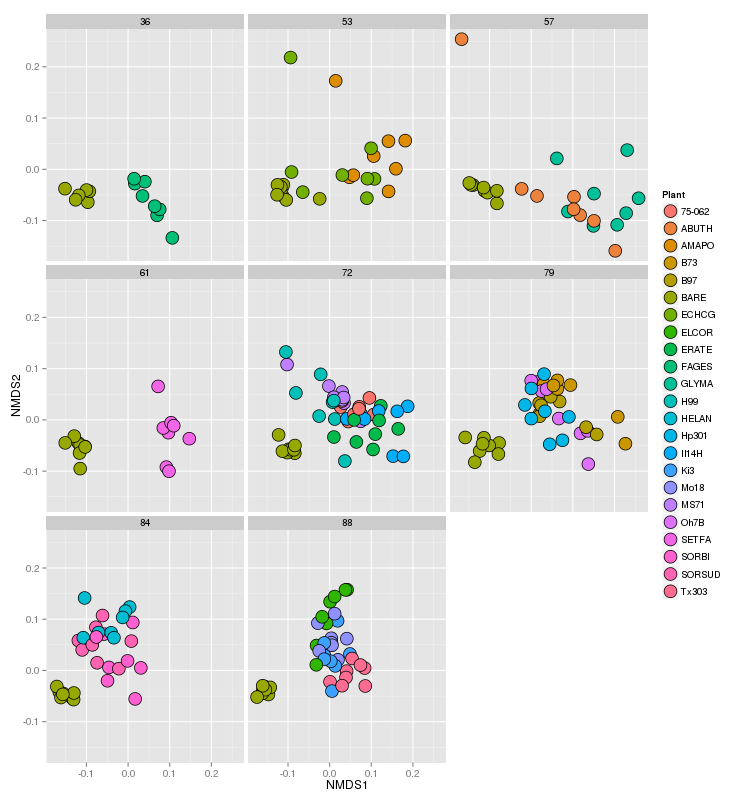

In [56]:
%%R -w 750 -h 800

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1


# Explore variance of treatments

In [57]:
%%R
#meandist function returns average within and between group distances
sd = sample_data(physeq.thresh)
MD = meandist(wunif.dist, sd$Plant)
#summary(MD)
#plot(MD, kind = "histogram")

diag(MD) #Diagonal of matrix returns the within group average distances

   75-062     ABUTH     AMAPO       B73       B97      BARE     ECHCG     ELCOR 
0.1663148 0.2569746 0.1841493 0.2052132 0.1404468 0.1006519 0.2564461 0.1434901 
    ERATE     FAGES     GLYMA       H99     HELAN     Hp301     Il14H       Ki3 
0.1674343 0.1415243 0.2337716 0.1907506 0.1591667 0.1747970 0.2024308 0.1517426 
     Mo18      MS71      Oh7B     SETFA     SORBI    SORSUD     Tx303 
0.1396678 0.1773676 0.2074215 0.1627866 0.1705169 0.1647750 0.1386816 


In [58]:
%%R
Spread = data.frame(diag(MD))
Spread$Sample = row.names(Spread)
Spread_ordered = arrange(Spread, diag.MD.)
Spread_ordered

    diag.MD. Sample
1  0.1006519   BARE
2  0.1386816  Tx303
3  0.1396678   Mo18
4  0.1404468    B97
5  0.1415243  FAGES
6  0.1434901  ELCOR
7  0.1517426    Ki3
8  0.1591667  HELAN
9  0.1627866  SETFA
10 0.1647750 SORSUD
11 0.1663148 75-062
12 0.1674343  ERATE
13 0.1705169  SORBI
14 0.1747970  Hp301
15 0.1773676   MS71
16 0.1841493  AMAPO
17 0.1907506    H99
18 0.2024308  Il14H
19 0.2052132    B73
20 0.2074215   Oh7B
21 0.2337716  GLYMA
22 0.2564461  ECHCG
23 0.2569746  ABUTH
